In [ ]:
# Import all the things we need ---
#   by setting env variables before Keras import you can set up which backend and which GPU it uses
import sys
#%matplotlib inline
import os,random
os.environ["KERAS_BACKEND"] = "theano"
#os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["THEANO_FLAGS"]  = "device=cpu"
import numpy as np
import theano as th
import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.recurrent import LSTM
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
import random, sys, keras

In [2]:
# Load the dataset ...
# You will need to separately download or generate this file from
# https://www.deepsig.io/datasets
# The file to get is RML2016.10a.tar.bz2
 
# you need an absolute path the file decompressed file so change the path.
# It is a pickle file for Python2 so a little extra code is needed to open it.
with open("RML2016.10a_dict.dat.pkl", 'rb') as f:
    Xd = cPickle.load(f, encoding="latin1") 
 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
snrs_chosen = [2,4,6,8,10,12,14,16,18]
mods_chosen = ['BPSK', 'GFSK', 'QAM16', 'QPSK', 'WBFM']

X = []
lbl = []
for mod in mods_chosen:
    # mod is the label. mod = modulation scheme
    for snr in snrs_chosen:
        X.append(Xd[(mod,snr)])
        #snr = signal to noise ratio
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

FileNotFoundError: [Errno 2] No such file or directory: 'RML2016.10a_dict.dat.pkl'

In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
# looks like taking half the samples for training
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
 
    data = list(yy)
 
    yy1 = np.zeros([len(data), max(data)+1])
    yy1[np.arange(len(data)),data] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods_chosen.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods_chosen.index(lbl[x][0]), test_idx))

In [ ]:
in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods_chosen

(22500, 2, 128) [2, 128]


In [ ]:
# Build VT-CNN2 Neural Net model using Keras primitives --
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization
 
dr = 0.6 # dropout rate (%)
 
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))
model.add(ZeroPadding2D((0, 1)))
model.add(Conv2D(10, (1, 2), padding='valid', input_shape=(1, 2, 128), activation="relu", kernel_initializer='glorot_uniform'))
model.add(Flatten())
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense( len(classes), kernel_initializer='he_normal'))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.build()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_9 (ZeroPaddin (None, 1, 4, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 3, 10)          2570      
_________________________________________________________________
flatten_5 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
activation_5 (Activation)    (None, 5)                

In [ ]:
# Set up some params
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
#weight written to jupyter directory (where notebook is). saved in hdf5 format.
 
#netron can open the h5 and show architecture of the neural network
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        #params determine when to save weights to file. Happens periodically during fit.
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished. best means lowest loss values for test/validation
model.load_weights(filepath)

Epoch 1/150
22/22 - 0s - loss: 1.6028 - val_loss: 1.5949
Epoch 2/150
22/22 - 0s - loss: 1.5851 - val_loss: 1.5707
Epoch 3/150
22/22 - 0s - loss: 1.5552 - val_loss: 1.5325
Epoch 4/150
22/22 - 0s - loss: 1.5109 - val_loss: 1.4810
Epoch 5/150
22/22 - 0s - loss: 1.4569 - val_loss: 1.4245
Epoch 6/150
22/22 - 0s - loss: 1.4032 - val_loss: 1.3742
Epoch 7/150
22/22 - 0s - loss: 1.3594 - val_loss: 1.3364
Epoch 8/150
22/22 - 0s - loss: 1.3263 - val_loss: 1.3069
Epoch 9/150
22/22 - 0s - loss: 1.2991 - val_loss: 1.2806
Epoch 10/150
22/22 - 0s - loss: 1.2741 - val_loss: 1.2563
Epoch 11/150
22/22 - 0s - loss: 1.2502 - val_loss: 1.2320
Epoch 12/150
22/22 - 0s - loss: 1.2259 - val_loss: 1.2070
Epoch 13/150
22/22 - 0s - loss: 1.2005 - val_loss: 1.1811
Epoch 14/150
22/22 - 0s - loss: 1.1753 - val_loss: 1.1567
Epoch 15/150
22/22 - 0s - loss: 1.1522 - val_loss: 1.1350
Epoch 16/150
22/22 - 0s - loss: 1.1319 - val_loss: 1.1163
Epoch 17/150
22/22 - 0s - loss: 1.1146 - val_loss: 1.1002
Epoch 18/150
22/22 - 0s

Epoch 142/150
22/22 - 0s - loss: 0.7449 - val_loss: 0.7523
Epoch 143/150
22/22 - 0s - loss: 0.7447 - val_loss: 0.7504
Epoch 144/150
22/22 - 0s - loss: 0.7438 - val_loss: 0.7499
Epoch 145/150
22/22 - 0s - loss: 0.7431 - val_loss: 0.7491
Epoch 146/150
22/22 - 0s - loss: 0.7426 - val_loss: 0.7492
Epoch 147/150
22/22 - 0s - loss: 0.7426 - val_loss: 0.7488
Epoch 148/150
22/22 - 0s - loss: 0.7420 - val_loss: 0.7486
Epoch 149/150
22/22 - 0s - loss: 0.7414 - val_loss: 0.7479
Epoch 150/150
22/22 - 0s - loss: 0.7408 - val_loss: 0.7474


In [ ]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print (score)

0.7474464178085327


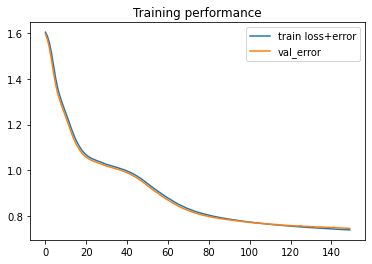

In [ ]:
# Show loss curves
# this is both on training and validation data, hence two curves. They track well.
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds, labels=[]):
    #plt.cm.Reds - color shades to use, Reds, Blues, etc.
    # made the image bigger- 800x800
    my_dpi=96
    plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
    #key call- data, how to interpolate thefp vakues, color map
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #adds a color legend to right hand side. Shows values for different shadings of blue.
    plt.colorbar()
    # create tickmarks with count = number of labels
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[5.99777283e-01 3.05122494e-02 1.91759465e-01 1.77951002e-01
  0.00000000e+00]
 [8.35164835e-03 9.27912088e-01 1.20879121e-02 4.39560440e-04
  5.12087912e-02]
 [2.97036372e-01 2.94117647e-02 3.34530759e-01 3.39021105e-01
  0.00000000e+00]
 [3.10837989e-01 2.27932961e-02 3.18435754e-01 3.47932961e-01
  0.00000000e+00]
 [2.20701832e-04 6.04723019e-02 1.32421099e-03 0.00000000e+00
  9.37982785e-01]]
['BPSK', 'GFSK', 'QAM16', 'QPSK', 'WBFM']


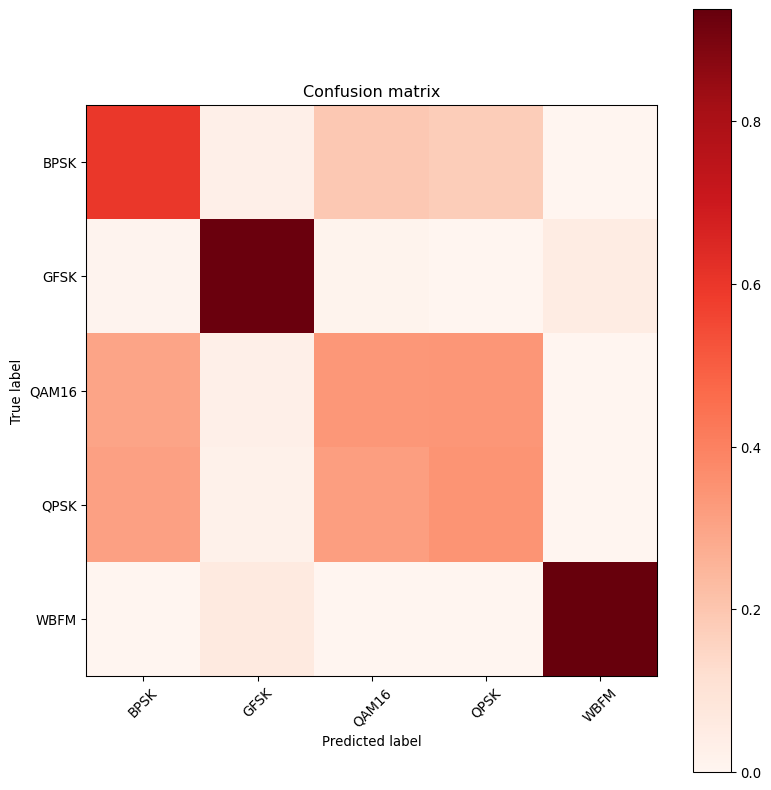

In [ ]:
# Plot confusion matrix
 
#pass in X_test value and it predicts test_Y_hat
test_Y_hat = model.predict(X_test, batch_size=batch_size)
#fill matrices with zeros
conf = np.zeros([len(classes),len(classes)])
#normalize confusion matrix
confnorm = np.zeros([len(classes),len(classes)])
 
#this puts all the data into an 11 x 11 matrix for plotting.
for i in range(0,X_test.shape[0]):
    # j is first value in list
    j = list(Y_test[i,:]).index(1)
    #np.argmax gives the index of the max value in the array, assuming flattened into single vector
    k = int(np.argmax(test_Y_hat[i,:]))
    #why add 1 to each value??
    conf[j,k] = conf[j,k] + 1
 
#takes the data to plot and normalizes it
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
print (confnorm)
print (classes)
plot_confusion_matrix(confnorm, labels=classes)

<Figure size 432x288 with 0 Axes>

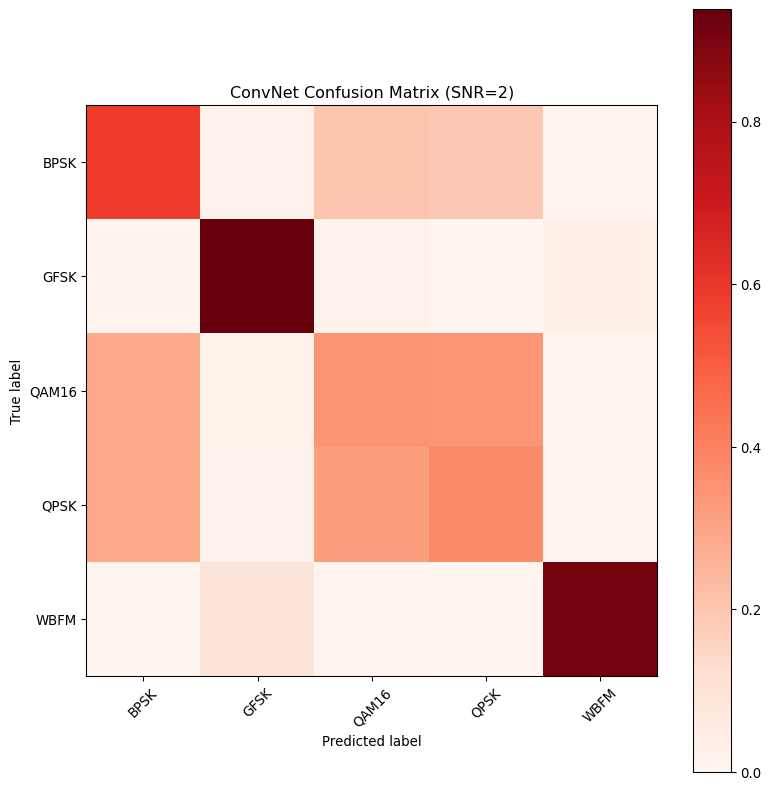

<Figure size 432x288 with 0 Axes>

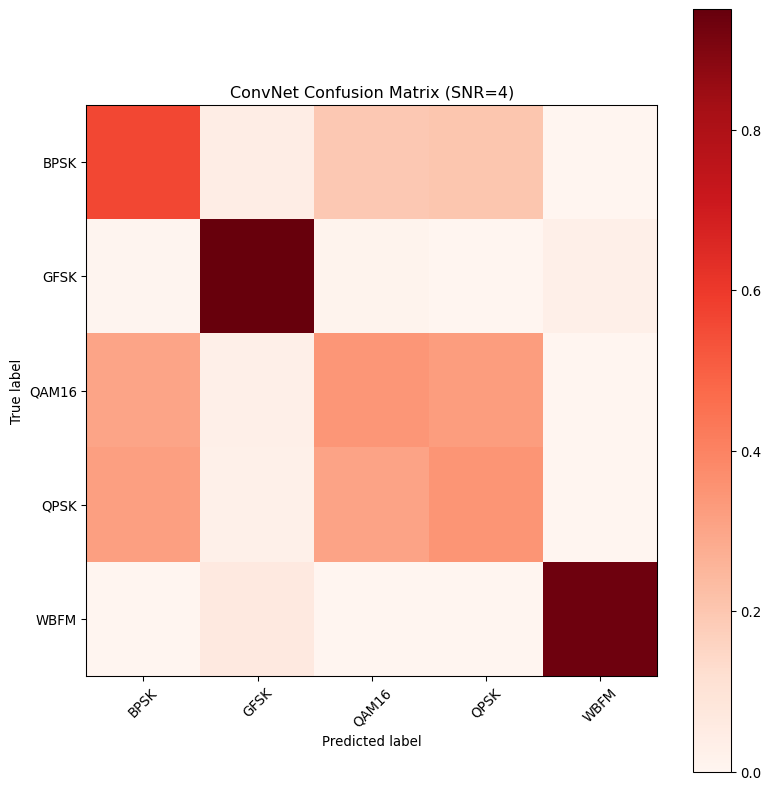

<Figure size 432x288 with 0 Axes>

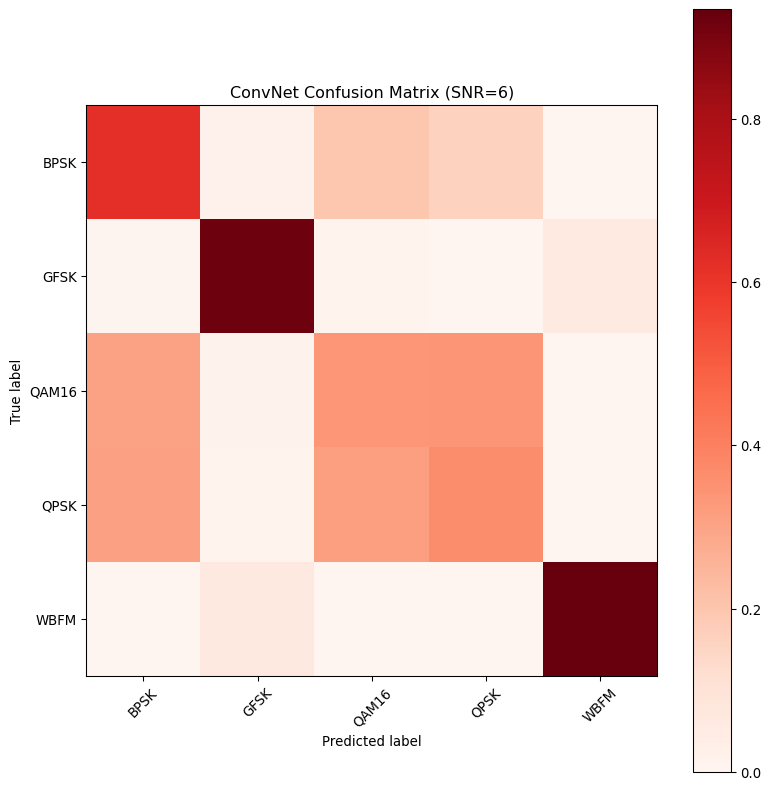

<Figure size 432x288 with 0 Axes>

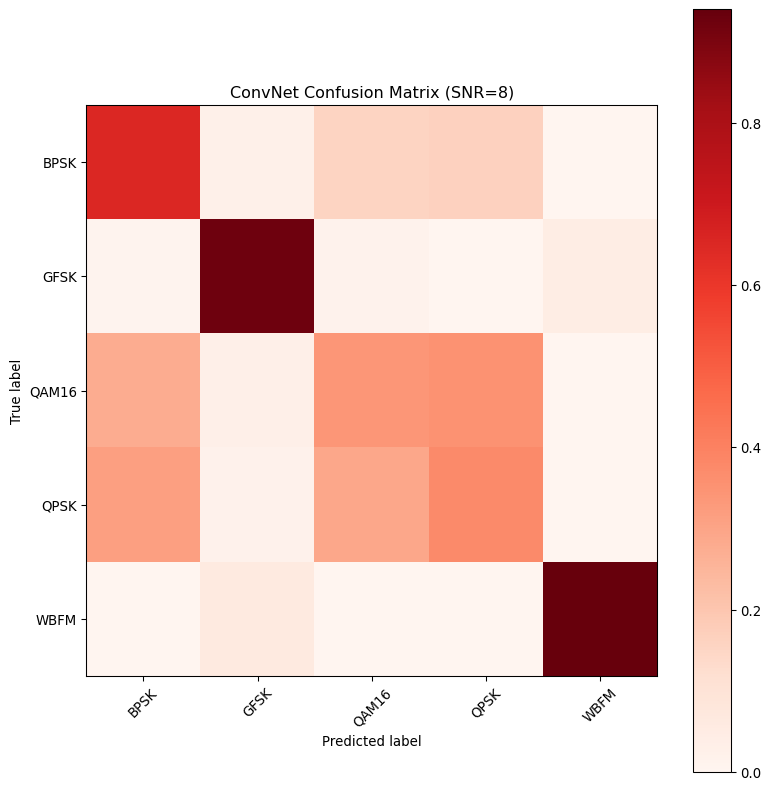

<Figure size 432x288 with 0 Axes>

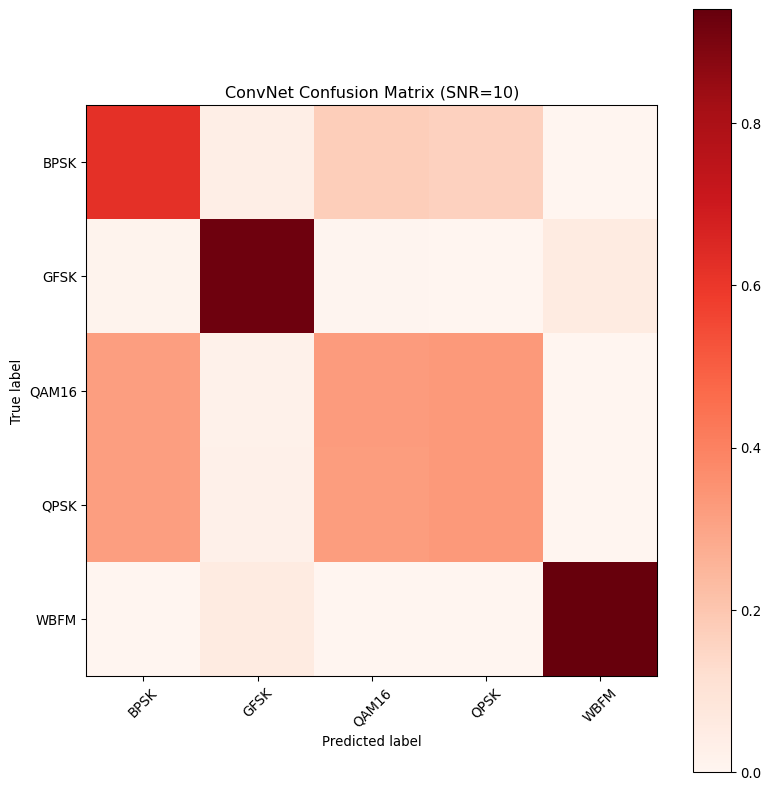

<Figure size 432x288 with 0 Axes>

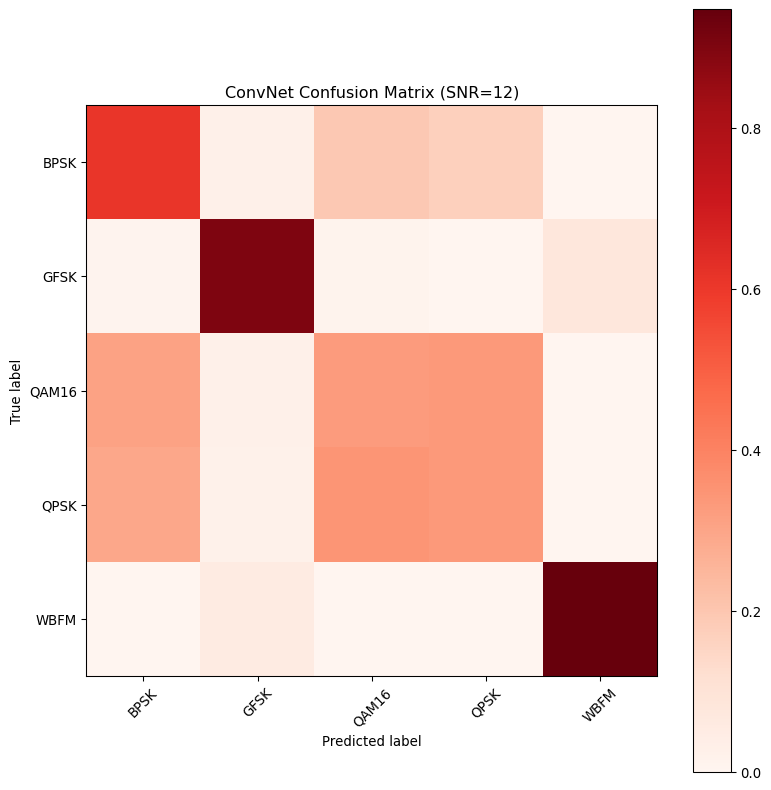

<Figure size 432x288 with 0 Axes>

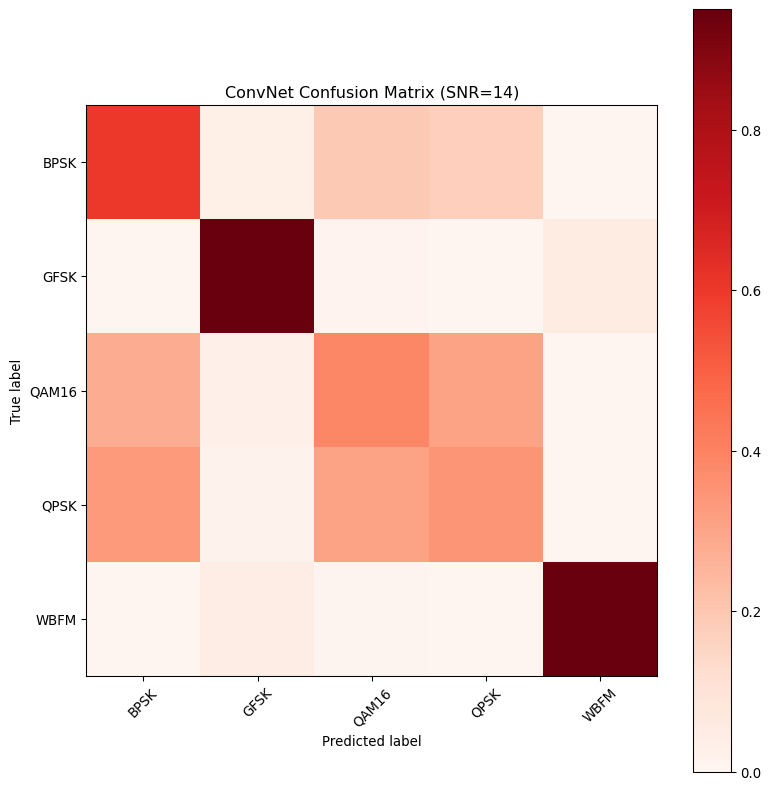

<Figure size 432x288 with 0 Axes>

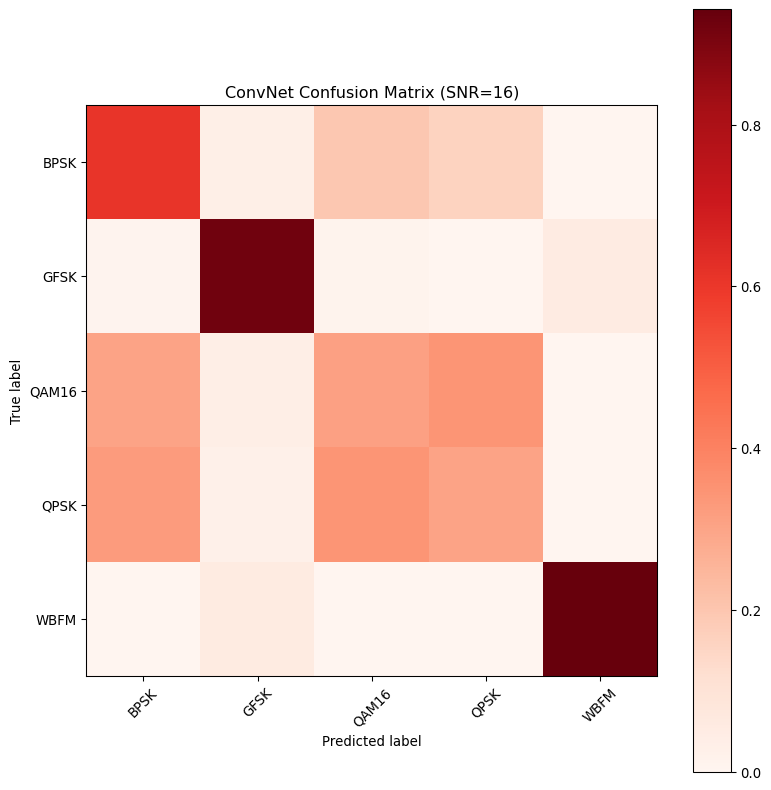

<Figure size 432x288 with 0 Axes>

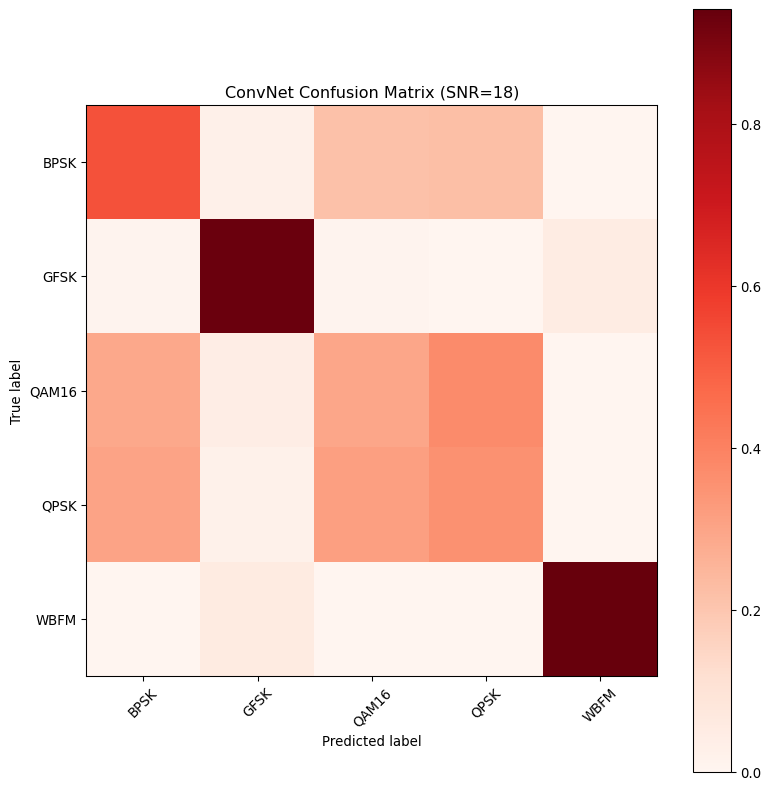

In [ ]:
# Plot confusion matrix
acc = {}
 
#this create a new confusion matrix for each SNR
for snr in snrs_chosen:
 
    # extract classes @ SNR
    #changed map to list as part of upgrade from python2
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
 
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
 
    #create 11x11 matrix full of zeroes
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
 
    #normalize 0 .. 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)

In [ ]:
# Save results to a pickle file for plotting later
print (acc)
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

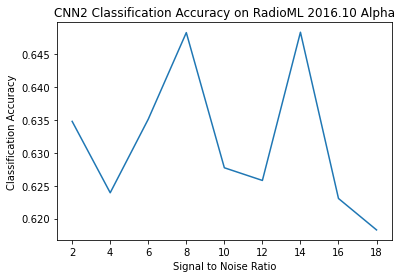

In [ ]:
# Plot accuracy curve
# map function produces generator in python3 which does not work with plt. Need a list.
# list(map(chr,[66,53,0,94]))
plt.plot(snrs_chosen, list(map(lambda x: acc[x], snrs_chosen)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")